In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torch
import time
import numpy as np
from torch import nn
from torch.nn import functional as F
import torchvision
import matplotlib.pyplot as plt

In [2]:
torch.autograd.set_detect_anomaly(True)

In [3]:
import dlc_practical_prologue as prologue

In [4]:
# load training and testing data
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

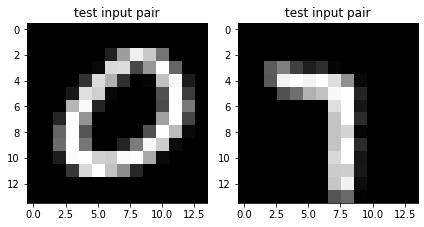

The test classes are: 0 and 7.
The test target is: 0


In [5]:
# discribe the data
fig = plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(test_input[0][i], cmap='gray')
  plt.title("test input pair")  
  plt.tight_layout()
plt.show()
print("The test classes are: %d and %d."%(test_classes[0][0].item(),test_classes[0][1].item()))
print("The test target is: %d"%(train_target[0]))

In [6]:
class residual_block(nn.Module):
    def __init__(self,input_channels,num_channels,use_one_conv=True):
        super().__init__()
        self.use_one_conv=use_one_conv
        self.conv1 = nn.Conv2d(input_channels,num_channels, kernel_size=3,padding=1,stride=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1,stride=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
        if self.use_one_conv:
            self.conv3 = nn.Conv2d(input_channels,num_channels,kernel_size=1,stride=1)
    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)
        if self.use_one_conv:
            x = self.conv3(x)  
            out=x+out
        return out

In [7]:
# Now we are going to build a ResNet, which is the stack of residual block.
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.block1=nn.Conv2d(2,16,7,2)
        self.block3 = nn.Sequential(
            nn.MaxPool2d(3, 2),
            residual_block(16, 32, False),
            residual_block(32, 32)
        )
        self.block4 = nn.Sequential(
            residual_block(32, 64, False),
            residual_block(64, 64)
        )
        self.block5 = nn.Sequential(
            residual_block(64, 128, False),
            residual_block(128, 128),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 2)
        
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
#         1 29
    def forward(self, x):
        x = self.block1(x)
#         x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x=x.view(-1, 128)        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # Training Function
    def trainer(self, train_input, train_target, test_input, test_target):
        """
        Train the model on a training set, and plot the loss and accuracy function
        Print the used time.
        :param train_input: Training input data
        :param train_target: Training labels
        :param test_input: Testing input data
        :param test_target: Testing labels
        """
        start_time = time.time()
        train_loss_history=[]
        test_loss_history=[]
        train_accuracy=[]
        test_accuracy=[]
        for epoch in range(self.num_epochs):
            self.train()
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output = self(train_input[batch_idx:batch_idx+self.batch_size]) 
                loss = self.criterion(output, train_target[batch_idx:batch_idx+self.batch_size])  
                self.optimizer.zero_grad()                          #set the weight and bias gradients to zero
                loss.backward()                                #backpropagation
                self.optimizer.step()
#                 # print the loss in every 50 epoch
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
            # test mode
            self.eval()
            # get the training loss and accuracy
            train_predicted = self(train_input)
            train_loss = self.criterion(train_predicted, train_target)
            train_loss_history.append(train_loss)
            _, train_pred = torch.max(train_predicted, 1)   #return the index of the bigger result
            train_accuracy_result=self.compute_accuracy(train_target,train_pred)
            train_accuracy.append(train_accuracy_result)

            # get the testing loss and accuracy
            test_predicted = self(test_input)
            test_loss = self.criterion(test_predicted, test_target)
            test_loss_history.append(test_loss)
            _, test_pred = torch.max(test_predicted, 1)   #return the index of the bigger result
            test_accuracy_result=self.compute_accuracy(test_target,test_pred)
            test_accuracy.append(test_accuracy_result)
            
        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        
        #Setting-up the plot
        plt.figure(figsize=(15,8))

        ax1 = plt.subplot(1,2,1)

        ax2 = plt.subplot(1,2,2)

        #Drawing and labeling the curves
        ax1.plot(train_loss_history, label="Training Loss")
        ax1.plot(test_loss_history, label="Test Loss")

        #Adding the title and axis labels
        ax1.set_title('Train VS Test Loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()

    #     #Saving the plot
    #     ax1.figure.savefig(model.model_name+'loss.png')


        #Drawing and labeling the curves
        ax2.plot(train_accuracy, label="Train Accuracy")
        ax2.plot(test_accuracy, label="Test Accuracy")

        #Adding the title and axis labels
        ax2.set_title('Train VS Test Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
    
        #test mode
        self.eval()
        outputs= self(input_data)
        _, predicted = torch.max(outputs, 1)
        return 1-self.compute_accuracy(target,predicted)
    
    def compute_accuracy(self, target, pred):
        """
        Compute the training and testing error
        :param target: target data (whether 1 or 0)
        :param pred: predicted data
        :return 
        """
        return (target-pred).eq(0).float().mean().item()
    
    
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+ model_name)        

In [8]:
# build the net instance
my_model=ResNet()
# save the model
my_model.save_model('ResNet.pth')

Epoch: 001/025 | Batch 000/1000 | Loss: 0.684769
Epoch: 001/025 | Batch 050/1000 | Loss: 0.703318
Epoch: 001/025 | Batch 100/1000 | Loss: 0.699412
Epoch: 001/025 | Batch 150/1000 | Loss: 0.729651
Epoch: 001/025 | Batch 200/1000 | Loss: 0.707222
Epoch: 001/025 | Batch 250/1000 | Loss: 0.642721
Epoch: 001/025 | Batch 300/1000 | Loss: 0.673718
Epoch: 001/025 | Batch 350/1000 | Loss: 0.660088
Epoch: 001/025 | Batch 400/1000 | Loss: 0.685411
Epoch: 001/025 | Batch 450/1000 | Loss: 0.649715
Epoch: 001/025 | Batch 500/1000 | Loss: 0.734330
Epoch: 001/025 | Batch 550/1000 | Loss: 0.759396
Epoch: 001/025 | Batch 600/1000 | Loss: 0.586950
Epoch: 001/025 | Batch 650/1000 | Loss: 0.749577
Epoch: 001/025 | Batch 700/1000 | Loss: 0.638914
Epoch: 001/025 | Batch 750/1000 | Loss: 0.626029
Epoch: 001/025 | Batch 800/1000 | Loss: 0.668164
Epoch: 001/025 | Batch 850/1000 | Loss: 0.738266
Epoch: 001/025 | Batch 900/1000 | Loss: 0.708809
Epoch: 001/025 | Batch 950/1000 | Loss: 0.724974
Time elapsed: 0.02 m

Epoch: 009/025 | Batch 300/1000 | Loss: 0.311833
Epoch: 009/025 | Batch 350/1000 | Loss: 0.147732
Epoch: 009/025 | Batch 400/1000 | Loss: 0.123057
Epoch: 009/025 | Batch 450/1000 | Loss: 0.259894
Epoch: 009/025 | Batch 500/1000 | Loss: 0.255811
Epoch: 009/025 | Batch 550/1000 | Loss: 0.165064
Epoch: 009/025 | Batch 600/1000 | Loss: 0.225087
Epoch: 009/025 | Batch 650/1000 | Loss: 0.152059
Epoch: 009/025 | Batch 700/1000 | Loss: 0.227653
Epoch: 009/025 | Batch 750/1000 | Loss: 0.147695
Epoch: 009/025 | Batch 800/1000 | Loss: 0.187283
Epoch: 009/025 | Batch 850/1000 | Loss: 0.248682
Epoch: 009/025 | Batch 900/1000 | Loss: 0.185282
Epoch: 009/025 | Batch 950/1000 | Loss: 0.246608
Time elapsed: 0.18 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.151511
Epoch: 010/025 | Batch 050/1000 | Loss: 0.264563
Epoch: 010/025 | Batch 100/1000 | Loss: 0.110182
Epoch: 010/025 | Batch 150/1000 | Loss: 0.135628
Epoch: 010/025 | Batch 200/1000 | Loss: 0.382686
Epoch: 010/025 | Batch 250/1000 | Loss: 0.1805

Epoch: 017/025 | Batch 600/1000 | Loss: 0.188346
Epoch: 017/025 | Batch 650/1000 | Loss: 0.067790
Epoch: 017/025 | Batch 700/1000 | Loss: 0.182397
Epoch: 017/025 | Batch 750/1000 | Loss: 0.053777
Epoch: 017/025 | Batch 800/1000 | Loss: 0.189820
Epoch: 017/025 | Batch 850/1000 | Loss: 0.085814
Epoch: 017/025 | Batch 900/1000 | Loss: 0.097109
Epoch: 017/025 | Batch 950/1000 | Loss: 0.067122
Time elapsed: 0.36 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.170118
Epoch: 018/025 | Batch 050/1000 | Loss: 0.185742
Epoch: 018/025 | Batch 100/1000 | Loss: 0.162892
Epoch: 018/025 | Batch 150/1000 | Loss: 0.103099
Epoch: 018/025 | Batch 200/1000 | Loss: 0.155892
Epoch: 018/025 | Batch 250/1000 | Loss: 0.112647
Epoch: 018/025 | Batch 300/1000 | Loss: 0.076399
Epoch: 018/025 | Batch 350/1000 | Loss: 0.066662
Epoch: 018/025 | Batch 400/1000 | Loss: 0.100289
Epoch: 018/025 | Batch 450/1000 | Loss: 0.072704
Epoch: 018/025 | Batch 500/1000 | Loss: 0.107332
Epoch: 018/025 | Batch 550/1000 | Loss: 0.1211

Epoch: 025/025 | Batch 950/1000 | Loss: 0.057586
Time elapsed: 0.54 min
Total Training Time: 0.54 min


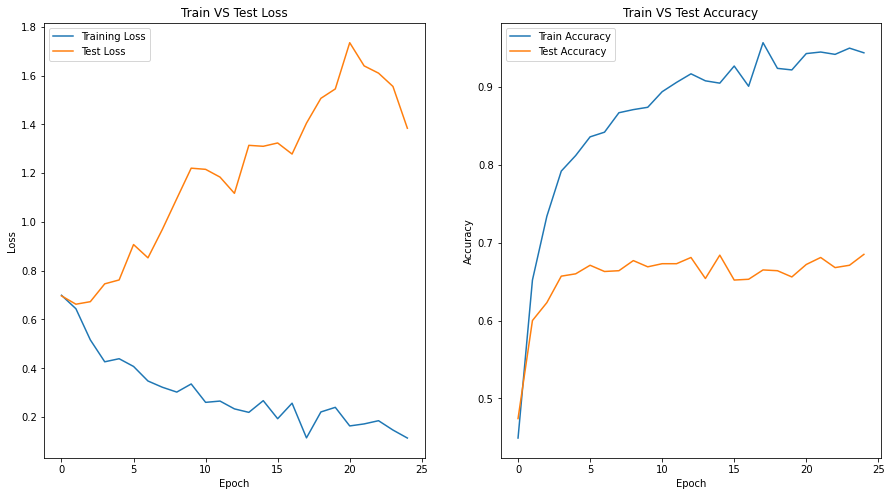

In [9]:
# train the model
my_model.trainer(train_input, train_target, test_input, test_target)

In [10]:
# output the total number of parameters
print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

The total number of the parameters is: 720146


Epoch: 001/025 | Batch 000/1000 | Loss: 0.708800
Epoch: 001/025 | Batch 050/1000 | Loss: 0.708724
Epoch: 001/025 | Batch 100/1000 | Loss: 0.762385
Epoch: 001/025 | Batch 150/1000 | Loss: 0.731883
Epoch: 001/025 | Batch 200/1000 | Loss: 0.679162
Epoch: 001/025 | Batch 250/1000 | Loss: 0.667738
Epoch: 001/025 | Batch 300/1000 | Loss: 0.704333
Epoch: 001/025 | Batch 350/1000 | Loss: 0.699995
Epoch: 001/025 | Batch 400/1000 | Loss: 0.742450
Epoch: 001/025 | Batch 450/1000 | Loss: 0.711731
Epoch: 001/025 | Batch 500/1000 | Loss: 0.675077
Epoch: 001/025 | Batch 550/1000 | Loss: 0.672055
Epoch: 001/025 | Batch 600/1000 | Loss: 0.670693
Epoch: 001/025 | Batch 650/1000 | Loss: 0.715624
Epoch: 001/025 | Batch 700/1000 | Loss: 0.725297
Epoch: 001/025 | Batch 750/1000 | Loss: 0.650671
Epoch: 001/025 | Batch 800/1000 | Loss: 0.680985
Epoch: 001/025 | Batch 850/1000 | Loss: 0.745489
Epoch: 001/025 | Batch 900/1000 | Loss: 0.696546
Epoch: 001/025 | Batch 950/1000 | Loss: 0.684410
Time elapsed: 0.02 m

Epoch: 009/025 | Batch 200/1000 | Loss: 0.431211
Epoch: 009/025 | Batch 250/1000 | Loss: 0.225452
Epoch: 009/025 | Batch 300/1000 | Loss: 0.245278
Epoch: 009/025 | Batch 350/1000 | Loss: 0.305298
Epoch: 009/025 | Batch 400/1000 | Loss: 0.263555
Epoch: 009/025 | Batch 450/1000 | Loss: 0.231423
Epoch: 009/025 | Batch 500/1000 | Loss: 0.495817
Epoch: 009/025 | Batch 550/1000 | Loss: 0.262621
Epoch: 009/025 | Batch 600/1000 | Loss: 0.319302
Epoch: 009/025 | Batch 650/1000 | Loss: 0.431529
Epoch: 009/025 | Batch 700/1000 | Loss: 0.281573
Epoch: 009/025 | Batch 750/1000 | Loss: 0.247657
Epoch: 009/025 | Batch 800/1000 | Loss: 0.176587
Epoch: 009/025 | Batch 850/1000 | Loss: 0.199657
Epoch: 009/025 | Batch 900/1000 | Loss: 0.206907
Epoch: 009/025 | Batch 950/1000 | Loss: 0.163746
Time elapsed: 0.19 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.386223
Epoch: 010/025 | Batch 050/1000 | Loss: 0.187946
Epoch: 010/025 | Batch 100/1000 | Loss: 0.249939
Epoch: 010/025 | Batch 150/1000 | Loss: 0.2007

Epoch: 017/025 | Batch 400/1000 | Loss: 0.045905
Epoch: 017/025 | Batch 450/1000 | Loss: 0.202771
Epoch: 017/025 | Batch 500/1000 | Loss: 0.191285
Epoch: 017/025 | Batch 550/1000 | Loss: 0.313629
Epoch: 017/025 | Batch 600/1000 | Loss: 0.130103
Epoch: 017/025 | Batch 650/1000 | Loss: 0.081645
Epoch: 017/025 | Batch 700/1000 | Loss: 0.115834
Epoch: 017/025 | Batch 750/1000 | Loss: 0.157274
Epoch: 017/025 | Batch 800/1000 | Loss: 0.378869
Epoch: 017/025 | Batch 850/1000 | Loss: 0.143596
Epoch: 017/025 | Batch 900/1000 | Loss: 0.141948
Epoch: 017/025 | Batch 950/1000 | Loss: 0.205620
Time elapsed: 0.37 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.344040
Epoch: 018/025 | Batch 050/1000 | Loss: 0.111452
Epoch: 018/025 | Batch 100/1000 | Loss: 0.239004
Epoch: 018/025 | Batch 150/1000 | Loss: 0.341325
Epoch: 018/025 | Batch 200/1000 | Loss: 0.225754
Epoch: 018/025 | Batch 250/1000 | Loss: 0.193487
Epoch: 018/025 | Batch 300/1000 | Loss: 0.281160
Epoch: 018/025 | Batch 350/1000 | Loss: 0.1809

Epoch: 025/025 | Batch 650/1000 | Loss: 0.064529
Epoch: 025/025 | Batch 700/1000 | Loss: 0.041429
Epoch: 025/025 | Batch 750/1000 | Loss: 0.075375
Epoch: 025/025 | Batch 800/1000 | Loss: 0.065409
Epoch: 025/025 | Batch 850/1000 | Loss: 0.011616
Epoch: 025/025 | Batch 900/1000 | Loss: 0.064429
Epoch: 025/025 | Batch 950/1000 | Loss: 0.028526
Time elapsed: 0.55 min
Total Training Time: 0.55 min
Epoch: 001/025 | Batch 000/1000 | Loss: 0.717509
Epoch: 001/025 | Batch 050/1000 | Loss: 0.689833
Epoch: 001/025 | Batch 100/1000 | Loss: 0.697092
Epoch: 001/025 | Batch 150/1000 | Loss: 0.705619
Epoch: 001/025 | Batch 200/1000 | Loss: 0.656206
Epoch: 001/025 | Batch 250/1000 | Loss: 0.736953
Epoch: 001/025 | Batch 300/1000 | Loss: 0.678320
Epoch: 001/025 | Batch 350/1000 | Loss: 0.800051
Epoch: 001/025 | Batch 400/1000 | Loss: 0.713712
Epoch: 001/025 | Batch 450/1000 | Loss: 0.651474
Epoch: 001/025 | Batch 500/1000 | Loss: 0.655039
Epoch: 001/025 | Batch 550/1000 | Loss: 0.666153
Epoch: 001/025 |

Epoch: 008/025 | Batch 800/1000 | Loss: 0.396198
Epoch: 008/025 | Batch 850/1000 | Loss: 0.360309
Epoch: 008/025 | Batch 900/1000 | Loss: 0.177065
Epoch: 008/025 | Batch 950/1000 | Loss: 0.256398
Time elapsed: 0.18 min
Epoch: 009/025 | Batch 000/1000 | Loss: 0.326280
Epoch: 009/025 | Batch 050/1000 | Loss: 0.249953
Epoch: 009/025 | Batch 100/1000 | Loss: 0.199606
Epoch: 009/025 | Batch 150/1000 | Loss: 0.389082
Epoch: 009/025 | Batch 200/1000 | Loss: 0.372001
Epoch: 009/025 | Batch 250/1000 | Loss: 0.362711
Epoch: 009/025 | Batch 300/1000 | Loss: 0.236599
Epoch: 009/025 | Batch 350/1000 | Loss: 0.251148
Epoch: 009/025 | Batch 400/1000 | Loss: 0.454715
Epoch: 009/025 | Batch 450/1000 | Loss: 0.215092
Epoch: 009/025 | Batch 500/1000 | Loss: 0.266155
Epoch: 009/025 | Batch 550/1000 | Loss: 0.226797
Epoch: 009/025 | Batch 600/1000 | Loss: 0.249796
Epoch: 009/025 | Batch 650/1000 | Loss: 0.212004
Epoch: 009/025 | Batch 700/1000 | Loss: 0.205654
Epoch: 009/025 | Batch 750/1000 | Loss: 0.2516

Epoch: 017/025 | Batch 000/1000 | Loss: 0.085753
Epoch: 017/025 | Batch 050/1000 | Loss: 0.164855
Epoch: 017/025 | Batch 100/1000 | Loss: 0.097308
Epoch: 017/025 | Batch 150/1000 | Loss: 0.039095
Epoch: 017/025 | Batch 200/1000 | Loss: 0.060641
Epoch: 017/025 | Batch 250/1000 | Loss: 0.094857
Epoch: 017/025 | Batch 300/1000 | Loss: 0.063867
Epoch: 017/025 | Batch 350/1000 | Loss: 0.191507
Epoch: 017/025 | Batch 400/1000 | Loss: 0.119148
Epoch: 017/025 | Batch 450/1000 | Loss: 0.021310
Epoch: 017/025 | Batch 500/1000 | Loss: 0.081067
Epoch: 017/025 | Batch 550/1000 | Loss: 0.073304
Epoch: 017/025 | Batch 600/1000 | Loss: 0.031273
Epoch: 017/025 | Batch 650/1000 | Loss: 0.109599
Epoch: 017/025 | Batch 700/1000 | Loss: 0.031450
Epoch: 017/025 | Batch 750/1000 | Loss: 0.016150
Epoch: 017/025 | Batch 800/1000 | Loss: 0.161495
Epoch: 017/025 | Batch 850/1000 | Loss: 0.134564
Epoch: 017/025 | Batch 900/1000 | Loss: 0.047746
Epoch: 017/025 | Batch 950/1000 | Loss: 0.038078
Time elapsed: 0.38 m

Epoch: 025/025 | Batch 350/1000 | Loss: 0.022670
Epoch: 025/025 | Batch 400/1000 | Loss: 0.005429
Epoch: 025/025 | Batch 450/1000 | Loss: 0.032858
Epoch: 025/025 | Batch 500/1000 | Loss: 0.027305
Epoch: 025/025 | Batch 550/1000 | Loss: 0.088442
Epoch: 025/025 | Batch 600/1000 | Loss: 0.025676
Epoch: 025/025 | Batch 650/1000 | Loss: 0.005703
Epoch: 025/025 | Batch 700/1000 | Loss: 0.018929
Epoch: 025/025 | Batch 750/1000 | Loss: 0.069061
Epoch: 025/025 | Batch 800/1000 | Loss: 0.005052
Epoch: 025/025 | Batch 850/1000 | Loss: 0.066375
Epoch: 025/025 | Batch 900/1000 | Loss: 0.220542
Epoch: 025/025 | Batch 950/1000 | Loss: 0.020934
Time elapsed: 0.57 min
Total Training Time: 0.57 min
Epoch: 001/025 | Batch 000/1000 | Loss: 0.692463
Epoch: 001/025 | Batch 050/1000 | Loss: 0.717263
Epoch: 001/025 | Batch 100/1000 | Loss: 0.677958
Epoch: 001/025 | Batch 150/1000 | Loss: 0.669039
Epoch: 001/025 | Batch 200/1000 | Loss: 0.729918
Epoch: 001/025 | Batch 250/1000 | Loss: 0.674683
Epoch: 001/025 |

Epoch: 008/025 | Batch 600/1000 | Loss: 0.455682
Epoch: 008/025 | Batch 650/1000 | Loss: 0.293392
Epoch: 008/025 | Batch 700/1000 | Loss: 0.373087
Epoch: 008/025 | Batch 750/1000 | Loss: 0.299188
Epoch: 008/025 | Batch 800/1000 | Loss: 0.301832
Epoch: 008/025 | Batch 850/1000 | Loss: 0.255705
Epoch: 008/025 | Batch 900/1000 | Loss: 0.234092
Epoch: 008/025 | Batch 950/1000 | Loss: 0.282105
Time elapsed: 0.21 min
Epoch: 009/025 | Batch 000/1000 | Loss: 0.229752
Epoch: 009/025 | Batch 050/1000 | Loss: 0.421538
Epoch: 009/025 | Batch 100/1000 | Loss: 0.314734
Epoch: 009/025 | Batch 150/1000 | Loss: 0.329469
Epoch: 009/025 | Batch 200/1000 | Loss: 0.489480
Epoch: 009/025 | Batch 250/1000 | Loss: 0.304593
Epoch: 009/025 | Batch 300/1000 | Loss: 0.235113
Epoch: 009/025 | Batch 350/1000 | Loss: 0.302543
Epoch: 009/025 | Batch 400/1000 | Loss: 0.266993
Epoch: 009/025 | Batch 450/1000 | Loss: 0.234220
Epoch: 009/025 | Batch 500/1000 | Loss: 0.217912
Epoch: 009/025 | Batch 550/1000 | Loss: 0.1921

Epoch: 016/025 | Batch 800/1000 | Loss: 0.167473
Epoch: 016/025 | Batch 850/1000 | Loss: 0.160771
Epoch: 016/025 | Batch 900/1000 | Loss: 0.117204
Epoch: 016/025 | Batch 950/1000 | Loss: 0.168228
Time elapsed: 0.43 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.141375
Epoch: 017/025 | Batch 050/1000 | Loss: 0.134317
Epoch: 017/025 | Batch 100/1000 | Loss: 0.231283
Epoch: 017/025 | Batch 150/1000 | Loss: 0.156651
Epoch: 017/025 | Batch 200/1000 | Loss: 0.099467
Epoch: 017/025 | Batch 250/1000 | Loss: 0.153599
Epoch: 017/025 | Batch 300/1000 | Loss: 0.092722
Epoch: 017/025 | Batch 350/1000 | Loss: 0.176607
Epoch: 017/025 | Batch 400/1000 | Loss: 0.225049
Epoch: 017/025 | Batch 450/1000 | Loss: 0.214483
Epoch: 017/025 | Batch 500/1000 | Loss: 0.127080
Epoch: 017/025 | Batch 550/1000 | Loss: 0.086722
Epoch: 017/025 | Batch 600/1000 | Loss: 0.153097
Epoch: 017/025 | Batch 650/1000 | Loss: 0.061263
Epoch: 017/025 | Batch 700/1000 | Loss: 0.129366
Epoch: 017/025 | Batch 750/1000 | Loss: 0.1433

Epoch: 025/025 | Batch 000/1000 | Loss: 0.035217
Epoch: 025/025 | Batch 050/1000 | Loss: 0.010796
Epoch: 025/025 | Batch 100/1000 | Loss: 0.120795
Epoch: 025/025 | Batch 150/1000 | Loss: 0.256269
Epoch: 025/025 | Batch 200/1000 | Loss: 0.099229
Epoch: 025/025 | Batch 250/1000 | Loss: 0.023473
Epoch: 025/025 | Batch 300/1000 | Loss: 0.128046
Epoch: 025/025 | Batch 350/1000 | Loss: 0.087411
Epoch: 025/025 | Batch 400/1000 | Loss: 0.043532
Epoch: 025/025 | Batch 450/1000 | Loss: 0.029610
Epoch: 025/025 | Batch 500/1000 | Loss: 0.060205
Epoch: 025/025 | Batch 550/1000 | Loss: 0.107884
Epoch: 025/025 | Batch 600/1000 | Loss: 0.045809
Epoch: 025/025 | Batch 650/1000 | Loss: 0.186343
Epoch: 025/025 | Batch 700/1000 | Loss: 0.210739
Epoch: 025/025 | Batch 750/1000 | Loss: 0.041032
Epoch: 025/025 | Batch 800/1000 | Loss: 0.219427
Epoch: 025/025 | Batch 850/1000 | Loss: 0.043816
Epoch: 025/025 | Batch 900/1000 | Loss: 0.080376
Epoch: 025/025 | Batch 950/1000 | Loss: 0.017007
Time elapsed: 0.65 m

Epoch: 008/025 | Batch 200/1000 | Loss: 0.303147
Epoch: 008/025 | Batch 250/1000 | Loss: 0.442814
Epoch: 008/025 | Batch 300/1000 | Loss: 0.490908
Epoch: 008/025 | Batch 350/1000 | Loss: 0.522568
Epoch: 008/025 | Batch 400/1000 | Loss: 0.387024
Epoch: 008/025 | Batch 450/1000 | Loss: 0.324109
Epoch: 008/025 | Batch 500/1000 | Loss: 0.465610
Epoch: 008/025 | Batch 550/1000 | Loss: 0.350537
Epoch: 008/025 | Batch 600/1000 | Loss: 0.474612
Epoch: 008/025 | Batch 650/1000 | Loss: 0.512146
Epoch: 008/025 | Batch 700/1000 | Loss: 0.386468
Epoch: 008/025 | Batch 750/1000 | Loss: 0.360232
Epoch: 008/025 | Batch 800/1000 | Loss: 0.335429
Epoch: 008/025 | Batch 850/1000 | Loss: 0.426789
Epoch: 008/025 | Batch 900/1000 | Loss: 0.416672
Epoch: 008/025 | Batch 950/1000 | Loss: 0.364307
Time elapsed: 0.20 min
Epoch: 009/025 | Batch 000/1000 | Loss: 0.369888
Epoch: 009/025 | Batch 050/1000 | Loss: 0.387248
Epoch: 009/025 | Batch 100/1000 | Loss: 0.388506
Epoch: 009/025 | Batch 150/1000 | Loss: 0.3076

Epoch: 016/025 | Batch 400/1000 | Loss: 0.181927
Epoch: 016/025 | Batch 450/1000 | Loss: 0.168364
Epoch: 016/025 | Batch 500/1000 | Loss: 0.372628
Epoch: 016/025 | Batch 550/1000 | Loss: 0.129334
Epoch: 016/025 | Batch 600/1000 | Loss: 0.085109
Epoch: 016/025 | Batch 650/1000 | Loss: 0.169271
Epoch: 016/025 | Batch 700/1000 | Loss: 0.128123
Epoch: 016/025 | Batch 750/1000 | Loss: 0.167172
Epoch: 016/025 | Batch 800/1000 | Loss: 0.241207
Epoch: 016/025 | Batch 850/1000 | Loss: 0.310801
Epoch: 016/025 | Batch 900/1000 | Loss: 0.186361
Epoch: 016/025 | Batch 950/1000 | Loss: 0.190959
Time elapsed: 0.38 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.118041
Epoch: 017/025 | Batch 050/1000 | Loss: 0.239208
Epoch: 017/025 | Batch 100/1000 | Loss: 0.175404
Epoch: 017/025 | Batch 150/1000 | Loss: 0.134274
Epoch: 017/025 | Batch 200/1000 | Loss: 0.192808
Epoch: 017/025 | Batch 250/1000 | Loss: 0.148494
Epoch: 017/025 | Batch 300/1000 | Loss: 0.127481
Epoch: 017/025 | Batch 350/1000 | Loss: 0.1770

Epoch: 024/025 | Batch 750/1000 | Loss: 0.137458
Epoch: 024/025 | Batch 800/1000 | Loss: 0.184652
Epoch: 024/025 | Batch 850/1000 | Loss: 0.023072
Epoch: 024/025 | Batch 900/1000 | Loss: 0.210439
Epoch: 024/025 | Batch 950/1000 | Loss: 0.299368
Time elapsed: 0.58 min
Epoch: 025/025 | Batch 000/1000 | Loss: 0.272734
Epoch: 025/025 | Batch 050/1000 | Loss: 0.191683
Epoch: 025/025 | Batch 100/1000 | Loss: 0.185381
Epoch: 025/025 | Batch 150/1000 | Loss: 0.124961
Epoch: 025/025 | Batch 200/1000 | Loss: 0.124025
Epoch: 025/025 | Batch 250/1000 | Loss: 0.150397
Epoch: 025/025 | Batch 300/1000 | Loss: 0.169340
Epoch: 025/025 | Batch 350/1000 | Loss: 0.408408
Epoch: 025/025 | Batch 400/1000 | Loss: 0.118213
Epoch: 025/025 | Batch 450/1000 | Loss: 0.169948
Epoch: 025/025 | Batch 500/1000 | Loss: 0.236180
Epoch: 025/025 | Batch 550/1000 | Loss: 0.178562
Epoch: 025/025 | Batch 600/1000 | Loss: 0.165489
Epoch: 025/025 | Batch 650/1000 | Loss: 0.147586
Epoch: 025/025 | Batch 700/1000 | Loss: 0.3462

Epoch: 007/025 | Batch 950/1000 | Loss: 0.326649
Time elapsed: 0.17 min
Epoch: 008/025 | Batch 000/1000 | Loss: 0.259803
Epoch: 008/025 | Batch 050/1000 | Loss: 0.488801
Epoch: 008/025 | Batch 100/1000 | Loss: 0.303576
Epoch: 008/025 | Batch 150/1000 | Loss: 0.360726
Epoch: 008/025 | Batch 200/1000 | Loss: 0.312633
Epoch: 008/025 | Batch 250/1000 | Loss: 0.358657
Epoch: 008/025 | Batch 300/1000 | Loss: 0.298956
Epoch: 008/025 | Batch 350/1000 | Loss: 0.368390
Epoch: 008/025 | Batch 400/1000 | Loss: 0.177558
Epoch: 008/025 | Batch 450/1000 | Loss: 0.262875
Epoch: 008/025 | Batch 500/1000 | Loss: 0.347517
Epoch: 008/025 | Batch 550/1000 | Loss: 0.272322
Epoch: 008/025 | Batch 600/1000 | Loss: 0.376934
Epoch: 008/025 | Batch 650/1000 | Loss: 0.311119
Epoch: 008/025 | Batch 700/1000 | Loss: 0.506930
Epoch: 008/025 | Batch 750/1000 | Loss: 0.360686
Epoch: 008/025 | Batch 800/1000 | Loss: 0.392675
Epoch: 008/025 | Batch 850/1000 | Loss: 0.359470
Epoch: 008/025 | Batch 900/1000 | Loss: 0.2266

Epoch: 016/025 | Batch 200/1000 | Loss: 0.193326
Epoch: 016/025 | Batch 250/1000 | Loss: 0.109691
Epoch: 016/025 | Batch 300/1000 | Loss: 0.183584
Epoch: 016/025 | Batch 350/1000 | Loss: 0.119489
Epoch: 016/025 | Batch 400/1000 | Loss: 0.177333
Epoch: 016/025 | Batch 450/1000 | Loss: 0.113741
Epoch: 016/025 | Batch 500/1000 | Loss: 0.120065
Epoch: 016/025 | Batch 550/1000 | Loss: 0.266310
Epoch: 016/025 | Batch 600/1000 | Loss: 0.228007
Epoch: 016/025 | Batch 650/1000 | Loss: 0.341967
Epoch: 016/025 | Batch 700/1000 | Loss: 0.204929
Epoch: 016/025 | Batch 750/1000 | Loss: 0.298766
Epoch: 016/025 | Batch 800/1000 | Loss: 0.116386
Epoch: 016/025 | Batch 850/1000 | Loss: 0.155846
Epoch: 016/025 | Batch 900/1000 | Loss: 0.073086
Epoch: 016/025 | Batch 950/1000 | Loss: 0.205729
Time elapsed: 0.39 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.088834
Epoch: 017/025 | Batch 050/1000 | Loss: 0.190680
Epoch: 017/025 | Batch 100/1000 | Loss: 0.056232
Epoch: 017/025 | Batch 150/1000 | Loss: 0.0304

Epoch: 024/025 | Batch 450/1000 | Loss: 0.034898
Epoch: 024/025 | Batch 500/1000 | Loss: 0.008947
Epoch: 024/025 | Batch 550/1000 | Loss: 0.421543
Epoch: 024/025 | Batch 600/1000 | Loss: 0.104040
Epoch: 024/025 | Batch 650/1000 | Loss: 0.124319
Epoch: 024/025 | Batch 700/1000 | Loss: 0.086939
Epoch: 024/025 | Batch 750/1000 | Loss: 0.158637
Epoch: 024/025 | Batch 800/1000 | Loss: 0.331770
Epoch: 024/025 | Batch 850/1000 | Loss: 0.139427
Epoch: 024/025 | Batch 900/1000 | Loss: 0.074116
Epoch: 024/025 | Batch 950/1000 | Loss: 0.214332
Time elapsed: 0.59 min
Epoch: 025/025 | Batch 000/1000 | Loss: 0.159785
Epoch: 025/025 | Batch 050/1000 | Loss: 0.288993
Epoch: 025/025 | Batch 100/1000 | Loss: 0.248597
Epoch: 025/025 | Batch 150/1000 | Loss: 0.287365
Epoch: 025/025 | Batch 200/1000 | Loss: 0.200816
Epoch: 025/025 | Batch 250/1000 | Loss: 0.159349
Epoch: 025/025 | Batch 300/1000 | Loss: 0.174469
Epoch: 025/025 | Batch 350/1000 | Loss: 0.206479
Epoch: 025/025 | Batch 400/1000 | Loss: 0.1817

Epoch: 007/025 | Batch 600/1000 | Loss: 0.224111
Epoch: 007/025 | Batch 650/1000 | Loss: 0.279555
Epoch: 007/025 | Batch 700/1000 | Loss: 0.303240
Epoch: 007/025 | Batch 750/1000 | Loss: 0.220183
Epoch: 007/025 | Batch 800/1000 | Loss: 0.269380
Epoch: 007/025 | Batch 850/1000 | Loss: 0.516300
Epoch: 007/025 | Batch 900/1000 | Loss: 0.237281
Epoch: 007/025 | Batch 950/1000 | Loss: 0.367503
Time elapsed: 0.20 min
Epoch: 008/025 | Batch 000/1000 | Loss: 0.325566
Epoch: 008/025 | Batch 050/1000 | Loss: 0.432260
Epoch: 008/025 | Batch 100/1000 | Loss: 0.204936
Epoch: 008/025 | Batch 150/1000 | Loss: 0.334337
Epoch: 008/025 | Batch 200/1000 | Loss: 0.514688
Epoch: 008/025 | Batch 250/1000 | Loss: 0.322658
Epoch: 008/025 | Batch 300/1000 | Loss: 0.210744
Epoch: 008/025 | Batch 350/1000 | Loss: 0.298624
Epoch: 008/025 | Batch 400/1000 | Loss: 0.344614
Epoch: 008/025 | Batch 450/1000 | Loss: 0.375638
Epoch: 008/025 | Batch 500/1000 | Loss: 0.286280
Epoch: 008/025 | Batch 550/1000 | Loss: 0.4014

Epoch: 015/025 | Batch 850/1000 | Loss: 0.097315
Epoch: 015/025 | Batch 900/1000 | Loss: 0.120573
Epoch: 015/025 | Batch 950/1000 | Loss: 0.239168
Time elapsed: 0.41 min
Epoch: 016/025 | Batch 000/1000 | Loss: 0.137896
Epoch: 016/025 | Batch 050/1000 | Loss: 0.137607
Epoch: 016/025 | Batch 100/1000 | Loss: 0.082028
Epoch: 016/025 | Batch 150/1000 | Loss: 0.099100
Epoch: 016/025 | Batch 200/1000 | Loss: 0.288567
Epoch: 016/025 | Batch 250/1000 | Loss: 0.195166
Epoch: 016/025 | Batch 300/1000 | Loss: 0.088565
Epoch: 016/025 | Batch 350/1000 | Loss: 0.108656
Epoch: 016/025 | Batch 400/1000 | Loss: 0.211279
Epoch: 016/025 | Batch 450/1000 | Loss: 0.126134
Epoch: 016/025 | Batch 500/1000 | Loss: 0.163509
Epoch: 016/025 | Batch 550/1000 | Loss: 0.090313
Epoch: 016/025 | Batch 600/1000 | Loss: 0.263144
Epoch: 016/025 | Batch 650/1000 | Loss: 0.122937
Epoch: 016/025 | Batch 700/1000 | Loss: 0.061233
Epoch: 016/025 | Batch 750/1000 | Loss: 0.099189
Epoch: 016/025 | Batch 800/1000 | Loss: 0.2599

Epoch: 024/025 | Batch 000/1000 | Loss: 0.110614
Epoch: 024/025 | Batch 050/1000 | Loss: 0.070503
Epoch: 024/025 | Batch 100/1000 | Loss: 0.084548
Epoch: 024/025 | Batch 150/1000 | Loss: 0.065765
Epoch: 024/025 | Batch 200/1000 | Loss: 0.236272
Epoch: 024/025 | Batch 250/1000 | Loss: 0.061340
Epoch: 024/025 | Batch 300/1000 | Loss: 0.029201
Epoch: 024/025 | Batch 350/1000 | Loss: 0.025031
Epoch: 024/025 | Batch 400/1000 | Loss: 0.195213
Epoch: 024/025 | Batch 450/1000 | Loss: 0.074608
Epoch: 024/025 | Batch 500/1000 | Loss: 0.037256
Epoch: 024/025 | Batch 550/1000 | Loss: 0.085468
Epoch: 024/025 | Batch 600/1000 | Loss: 0.094909
Epoch: 024/025 | Batch 650/1000 | Loss: 0.069327
Epoch: 024/025 | Batch 700/1000 | Loss: 0.028124
Epoch: 024/025 | Batch 750/1000 | Loss: 0.046575
Epoch: 024/025 | Batch 800/1000 | Loss: 0.153202
Epoch: 024/025 | Batch 850/1000 | Loss: 0.037977
Epoch: 024/025 | Batch 900/1000 | Loss: 0.119846
Epoch: 024/025 | Batch 950/1000 | Loss: 0.086049
Time elapsed: 0.67 m

Epoch: 007/025 | Batch 200/1000 | Loss: 0.539326
Epoch: 007/025 | Batch 250/1000 | Loss: 0.254578
Epoch: 007/025 | Batch 300/1000 | Loss: 0.498613
Epoch: 007/025 | Batch 350/1000 | Loss: 0.262847
Epoch: 007/025 | Batch 400/1000 | Loss: 0.432323
Epoch: 007/025 | Batch 450/1000 | Loss: 0.362869
Epoch: 007/025 | Batch 500/1000 | Loss: 0.319766
Epoch: 007/025 | Batch 550/1000 | Loss: 0.382842
Epoch: 007/025 | Batch 600/1000 | Loss: 0.390944
Epoch: 007/025 | Batch 650/1000 | Loss: 0.415534
Epoch: 007/025 | Batch 700/1000 | Loss: 0.262066
Epoch: 007/025 | Batch 750/1000 | Loss: 0.479690
Epoch: 007/025 | Batch 800/1000 | Loss: 0.273240
Epoch: 007/025 | Batch 850/1000 | Loss: 0.321260
Epoch: 007/025 | Batch 900/1000 | Loss: 0.379425
Epoch: 007/025 | Batch 950/1000 | Loss: 0.583612
Time elapsed: 0.22 min
Epoch: 008/025 | Batch 000/1000 | Loss: 0.378374
Epoch: 008/025 | Batch 050/1000 | Loss: 0.358259
Epoch: 008/025 | Batch 100/1000 | Loss: 0.360909
Epoch: 008/025 | Batch 150/1000 | Loss: 0.3642

Epoch: 015/025 | Batch 500/1000 | Loss: 0.214971
Epoch: 015/025 | Batch 550/1000 | Loss: 0.229284
Epoch: 015/025 | Batch 600/1000 | Loss: 0.117399
Epoch: 015/025 | Batch 650/1000 | Loss: 0.147637
Epoch: 015/025 | Batch 700/1000 | Loss: 0.122559
Epoch: 015/025 | Batch 750/1000 | Loss: 0.218968
Epoch: 015/025 | Batch 800/1000 | Loss: 0.131513
Epoch: 015/025 | Batch 850/1000 | Loss: 0.136199
Epoch: 015/025 | Batch 900/1000 | Loss: 0.098340
Epoch: 015/025 | Batch 950/1000 | Loss: 0.459336
Time elapsed: 0.45 min
Epoch: 016/025 | Batch 000/1000 | Loss: 0.331298
Epoch: 016/025 | Batch 050/1000 | Loss: 0.238442
Epoch: 016/025 | Batch 100/1000 | Loss: 0.384267
Epoch: 016/025 | Batch 150/1000 | Loss: 0.286165
Epoch: 016/025 | Batch 200/1000 | Loss: 0.336269
Epoch: 016/025 | Batch 250/1000 | Loss: 0.176861
Epoch: 016/025 | Batch 300/1000 | Loss: 0.255195
Epoch: 016/025 | Batch 350/1000 | Loss: 0.219762
Epoch: 016/025 | Batch 400/1000 | Loss: 0.375274
Epoch: 016/025 | Batch 450/1000 | Loss: 0.4110

Epoch: 023/025 | Batch 800/1000 | Loss: 0.130535
Epoch: 023/025 | Batch 850/1000 | Loss: 0.095189
Epoch: 023/025 | Batch 900/1000 | Loss: 0.116954
Epoch: 023/025 | Batch 950/1000 | Loss: 0.179460
Time elapsed: 0.69 min
Epoch: 024/025 | Batch 000/1000 | Loss: 0.066813
Epoch: 024/025 | Batch 050/1000 | Loss: 0.067278
Epoch: 024/025 | Batch 100/1000 | Loss: 0.162935
Epoch: 024/025 | Batch 150/1000 | Loss: 0.087377
Epoch: 024/025 | Batch 200/1000 | Loss: 0.152533
Epoch: 024/025 | Batch 250/1000 | Loss: 0.141200
Epoch: 024/025 | Batch 300/1000 | Loss: 0.111168
Epoch: 024/025 | Batch 350/1000 | Loss: 0.142766
Epoch: 024/025 | Batch 400/1000 | Loss: 0.116425
Epoch: 024/025 | Batch 450/1000 | Loss: 0.106543
Epoch: 024/025 | Batch 500/1000 | Loss: 0.098982
Epoch: 024/025 | Batch 550/1000 | Loss: 0.094840
Epoch: 024/025 | Batch 600/1000 | Loss: 0.057570
Epoch: 024/025 | Batch 650/1000 | Loss: 0.168465
Epoch: 024/025 | Batch 700/1000 | Loss: 0.152700
Epoch: 024/025 | Batch 750/1000 | Loss: 0.0773

Epoch: 007/025 | Batch 000/1000 | Loss: 0.338953
Epoch: 007/025 | Batch 050/1000 | Loss: 0.307426
Epoch: 007/025 | Batch 100/1000 | Loss: 0.346820
Epoch: 007/025 | Batch 150/1000 | Loss: 0.348205
Epoch: 007/025 | Batch 200/1000 | Loss: 0.261739
Epoch: 007/025 | Batch 250/1000 | Loss: 0.289963
Epoch: 007/025 | Batch 300/1000 | Loss: 0.400306
Epoch: 007/025 | Batch 350/1000 | Loss: 0.317069
Epoch: 007/025 | Batch 400/1000 | Loss: 0.428351
Epoch: 007/025 | Batch 450/1000 | Loss: 0.501105
Epoch: 007/025 | Batch 500/1000 | Loss: 0.439245
Epoch: 007/025 | Batch 550/1000 | Loss: 0.348185
Epoch: 007/025 | Batch 600/1000 | Loss: 0.463086
Epoch: 007/025 | Batch 650/1000 | Loss: 0.269407
Epoch: 007/025 | Batch 700/1000 | Loss: 0.287985
Epoch: 007/025 | Batch 750/1000 | Loss: 0.504797
Epoch: 007/025 | Batch 800/1000 | Loss: 0.368013
Epoch: 007/025 | Batch 850/1000 | Loss: 0.476087
Epoch: 007/025 | Batch 900/1000 | Loss: 0.243972
Epoch: 007/025 | Batch 950/1000 | Loss: 0.355632
Time elapsed: 0.21 m

Epoch: 015/025 | Batch 300/1000 | Loss: 0.149467
Epoch: 015/025 | Batch 350/1000 | Loss: 0.044061
Epoch: 015/025 | Batch 400/1000 | Loss: 0.107901
Epoch: 015/025 | Batch 450/1000 | Loss: 0.099130
Epoch: 015/025 | Batch 500/1000 | Loss: 0.034263
Epoch: 015/025 | Batch 550/1000 | Loss: 0.111317
Epoch: 015/025 | Batch 600/1000 | Loss: 0.049561
Epoch: 015/025 | Batch 650/1000 | Loss: 0.166877
Epoch: 015/025 | Batch 700/1000 | Loss: 0.130236
Epoch: 015/025 | Batch 750/1000 | Loss: 0.230591
Epoch: 015/025 | Batch 800/1000 | Loss: 0.323929
Epoch: 015/025 | Batch 850/1000 | Loss: 0.261194
Epoch: 015/025 | Batch 900/1000 | Loss: 0.248456
Epoch: 015/025 | Batch 950/1000 | Loss: 0.076784
Time elapsed: 0.46 min
Epoch: 016/025 | Batch 000/1000 | Loss: 0.098892
Epoch: 016/025 | Batch 050/1000 | Loss: 0.183483
Epoch: 016/025 | Batch 100/1000 | Loss: 0.209955
Epoch: 016/025 | Batch 150/1000 | Loss: 0.089656
Epoch: 016/025 | Batch 200/1000 | Loss: 0.188634
Epoch: 016/025 | Batch 250/1000 | Loss: 0.1568

Epoch: 023/025 | Batch 600/1000 | Loss: 0.020099
Epoch: 023/025 | Batch 650/1000 | Loss: 0.029496
Epoch: 023/025 | Batch 700/1000 | Loss: 0.018294
Epoch: 023/025 | Batch 750/1000 | Loss: 0.095145
Epoch: 023/025 | Batch 800/1000 | Loss: 0.125189
Epoch: 023/025 | Batch 850/1000 | Loss: 0.096549
Epoch: 023/025 | Batch 900/1000 | Loss: 0.064100
Epoch: 023/025 | Batch 950/1000 | Loss: 0.010028
Time elapsed: 0.70 min
Epoch: 024/025 | Batch 000/1000 | Loss: 0.050479
Epoch: 024/025 | Batch 050/1000 | Loss: 0.089035
Epoch: 024/025 | Batch 100/1000 | Loss: 0.058517
Epoch: 024/025 | Batch 150/1000 | Loss: 0.030186
Epoch: 024/025 | Batch 200/1000 | Loss: 0.049146
Epoch: 024/025 | Batch 250/1000 | Loss: 0.257494
Epoch: 024/025 | Batch 300/1000 | Loss: 0.062597
Epoch: 024/025 | Batch 350/1000 | Loss: 0.120460
Epoch: 024/025 | Batch 400/1000 | Loss: 0.014468
Epoch: 024/025 | Batch 450/1000 | Loss: 0.067746
Epoch: 024/025 | Batch 500/1000 | Loss: 0.075172
Epoch: 024/025 | Batch 550/1000 | Loss: 0.0815

Epoch: 006/025 | Batch 750/1000 | Loss: 0.318405
Epoch: 006/025 | Batch 800/1000 | Loss: 0.342373
Epoch: 006/025 | Batch 850/1000 | Loss: 0.445148
Epoch: 006/025 | Batch 900/1000 | Loss: 0.510624
Epoch: 006/025 | Batch 950/1000 | Loss: 0.435980
Time elapsed: 0.14 min
Epoch: 007/025 | Batch 000/1000 | Loss: 0.281991
Epoch: 007/025 | Batch 050/1000 | Loss: 0.471442
Epoch: 007/025 | Batch 100/1000 | Loss: 0.406692
Epoch: 007/025 | Batch 150/1000 | Loss: 0.349549
Epoch: 007/025 | Batch 200/1000 | Loss: 0.345119
Epoch: 007/025 | Batch 250/1000 | Loss: 0.450252
Epoch: 007/025 | Batch 300/1000 | Loss: 0.528058
Epoch: 007/025 | Batch 350/1000 | Loss: 0.460908
Epoch: 007/025 | Batch 400/1000 | Loss: 0.324537
Epoch: 007/025 | Batch 450/1000 | Loss: 0.381241
Epoch: 007/025 | Batch 500/1000 | Loss: 0.384698
Epoch: 007/025 | Batch 550/1000 | Loss: 0.323068
Epoch: 007/025 | Batch 600/1000 | Loss: 0.300701
Epoch: 007/025 | Batch 650/1000 | Loss: 0.263037
Epoch: 007/025 | Batch 700/1000 | Loss: 0.3795

Epoch: 014/025 | Batch 950/1000 | Loss: 0.129112
Time elapsed: 0.33 min
Epoch: 015/025 | Batch 000/1000 | Loss: 0.038100
Epoch: 015/025 | Batch 050/1000 | Loss: 0.151090
Epoch: 015/025 | Batch 100/1000 | Loss: 0.141629
Epoch: 015/025 | Batch 150/1000 | Loss: 0.296824
Epoch: 015/025 | Batch 200/1000 | Loss: 0.074903
Epoch: 015/025 | Batch 250/1000 | Loss: 0.251811
Epoch: 015/025 | Batch 300/1000 | Loss: 0.204547
Epoch: 015/025 | Batch 350/1000 | Loss: 0.073508
Epoch: 015/025 | Batch 400/1000 | Loss: 0.254921
Epoch: 015/025 | Batch 450/1000 | Loss: 0.149689
Epoch: 015/025 | Batch 500/1000 | Loss: 0.188303
Epoch: 015/025 | Batch 550/1000 | Loss: 0.184629
Epoch: 015/025 | Batch 600/1000 | Loss: 0.167471
Epoch: 015/025 | Batch 650/1000 | Loss: 0.052085
Epoch: 015/025 | Batch 700/1000 | Loss: 0.292161
Epoch: 015/025 | Batch 750/1000 | Loss: 0.164398
Epoch: 015/025 | Batch 800/1000 | Loss: 0.072193
Epoch: 015/025 | Batch 850/1000 | Loss: 0.225594
Epoch: 015/025 | Batch 900/1000 | Loss: 0.2225

Epoch: 023/025 | Batch 150/1000 | Loss: 0.252011
Epoch: 023/025 | Batch 200/1000 | Loss: 0.244096
Epoch: 023/025 | Batch 250/1000 | Loss: 0.171804
Epoch: 023/025 | Batch 300/1000 | Loss: 0.111878
Epoch: 023/025 | Batch 350/1000 | Loss: 0.122843
Epoch: 023/025 | Batch 400/1000 | Loss: 0.128563
Epoch: 023/025 | Batch 450/1000 | Loss: 0.219864
Epoch: 023/025 | Batch 500/1000 | Loss: 0.113018
Epoch: 023/025 | Batch 550/1000 | Loss: 0.077527
Epoch: 023/025 | Batch 600/1000 | Loss: 0.092688
Epoch: 023/025 | Batch 650/1000 | Loss: 0.130712
Epoch: 023/025 | Batch 700/1000 | Loss: 0.132690
Epoch: 023/025 | Batch 750/1000 | Loss: 0.148064
Epoch: 023/025 | Batch 800/1000 | Loss: 0.069077
Epoch: 023/025 | Batch 850/1000 | Loss: 0.176055
Epoch: 023/025 | Batch 900/1000 | Loss: 0.165675
Epoch: 023/025 | Batch 950/1000 | Loss: 0.099769
Time elapsed: 0.57 min
Epoch: 024/025 | Batch 000/1000 | Loss: 0.070805
Epoch: 024/025 | Batch 050/1000 | Loss: 0.094178
Epoch: 024/025 | Batch 100/1000 | Loss: 0.0539

Epoch: 006/025 | Batch 300/1000 | Loss: 0.466157
Epoch: 006/025 | Batch 350/1000 | Loss: 0.409946
Epoch: 006/025 | Batch 400/1000 | Loss: 0.400251
Epoch: 006/025 | Batch 450/1000 | Loss: 0.329266
Epoch: 006/025 | Batch 500/1000 | Loss: 0.544747
Epoch: 006/025 | Batch 550/1000 | Loss: 0.604542
Epoch: 006/025 | Batch 600/1000 | Loss: 0.474911
Epoch: 006/025 | Batch 650/1000 | Loss: 0.371412
Epoch: 006/025 | Batch 700/1000 | Loss: 0.327459
Epoch: 006/025 | Batch 750/1000 | Loss: 0.417103
Epoch: 006/025 | Batch 800/1000 | Loss: 0.372728
Epoch: 006/025 | Batch 850/1000 | Loss: 0.390555
Epoch: 006/025 | Batch 900/1000 | Loss: 0.402942
Epoch: 006/025 | Batch 950/1000 | Loss: 0.457220
Time elapsed: 0.16 min
Epoch: 007/025 | Batch 000/1000 | Loss: 0.373495
Epoch: 007/025 | Batch 050/1000 | Loss: 0.350881
Epoch: 007/025 | Batch 100/1000 | Loss: 0.452800
Epoch: 007/025 | Batch 150/1000 | Loss: 0.425215
Epoch: 007/025 | Batch 200/1000 | Loss: 0.410949
Epoch: 007/025 | Batch 250/1000 | Loss: 0.3332

Epoch: 014/025 | Batch 550/1000 | Loss: 0.175314
Epoch: 014/025 | Batch 600/1000 | Loss: 0.193560
Epoch: 014/025 | Batch 650/1000 | Loss: 0.215025
Epoch: 014/025 | Batch 700/1000 | Loss: 0.124548
Epoch: 014/025 | Batch 750/1000 | Loss: 0.082692
Epoch: 014/025 | Batch 800/1000 | Loss: 0.058635
Epoch: 014/025 | Batch 850/1000 | Loss: 0.100830
Epoch: 014/025 | Batch 900/1000 | Loss: 0.056263
Epoch: 014/025 | Batch 950/1000 | Loss: 0.174616
Time elapsed: 0.45 min
Epoch: 015/025 | Batch 000/1000 | Loss: 0.150872
Epoch: 015/025 | Batch 050/1000 | Loss: 0.063017
Epoch: 015/025 | Batch 100/1000 | Loss: 0.245995
Epoch: 015/025 | Batch 150/1000 | Loss: 0.251490
Epoch: 015/025 | Batch 200/1000 | Loss: 0.185132
Epoch: 015/025 | Batch 250/1000 | Loss: 0.170191
Epoch: 015/025 | Batch 300/1000 | Loss: 0.129860
Epoch: 015/025 | Batch 350/1000 | Loss: 0.124641
Epoch: 015/025 | Batch 400/1000 | Loss: 0.089899
Epoch: 015/025 | Batch 450/1000 | Loss: 0.123629
Epoch: 015/025 | Batch 500/1000 | Loss: 0.2907

Epoch: 022/025 | Batch 750/1000 | Loss: 0.014167
Epoch: 022/025 | Batch 800/1000 | Loss: 0.015975
Epoch: 022/025 | Batch 850/1000 | Loss: 0.044519
Epoch: 022/025 | Batch 900/1000 | Loss: 0.009358
Epoch: 022/025 | Batch 950/1000 | Loss: 0.152556
Time elapsed: 0.71 min
Epoch: 023/025 | Batch 000/1000 | Loss: 0.215685
Epoch: 023/025 | Batch 050/1000 | Loss: 0.048063
Epoch: 023/025 | Batch 100/1000 | Loss: 0.013623
Epoch: 023/025 | Batch 150/1000 | Loss: 0.078969
Epoch: 023/025 | Batch 200/1000 | Loss: 0.170094
Epoch: 023/025 | Batch 250/1000 | Loss: 0.081805
Epoch: 023/025 | Batch 300/1000 | Loss: 0.231030
Epoch: 023/025 | Batch 350/1000 | Loss: 0.051334
Epoch: 023/025 | Batch 400/1000 | Loss: 0.126598
Epoch: 023/025 | Batch 450/1000 | Loss: 0.038844
Epoch: 023/025 | Batch 500/1000 | Loss: 0.239186
Epoch: 023/025 | Batch 550/1000 | Loss: 0.156446
Epoch: 023/025 | Batch 600/1000 | Loss: 0.287208
Epoch: 023/025 | Batch 650/1000 | Loss: 0.051627
Epoch: 023/025 | Batch 700/1000 | Loss: 0.0389

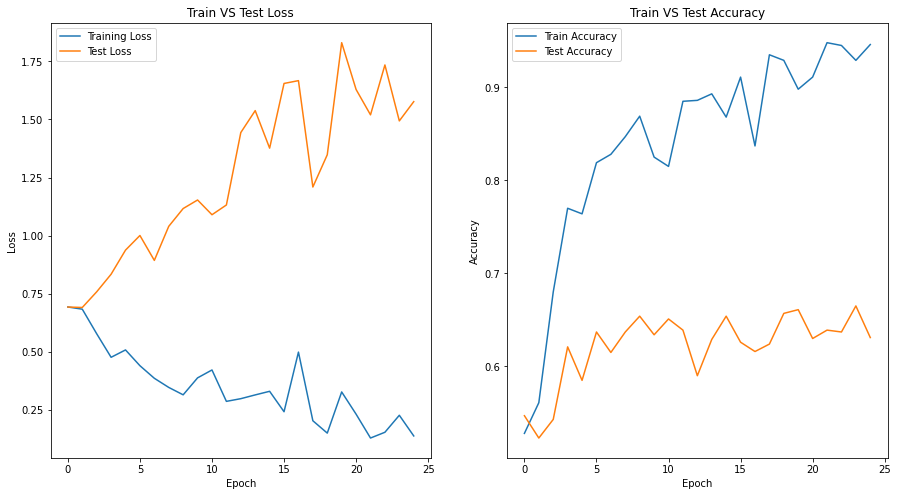

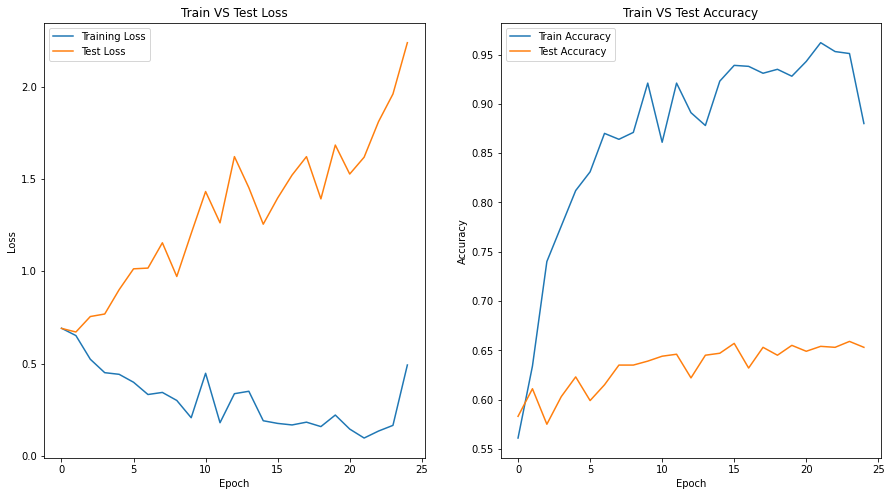

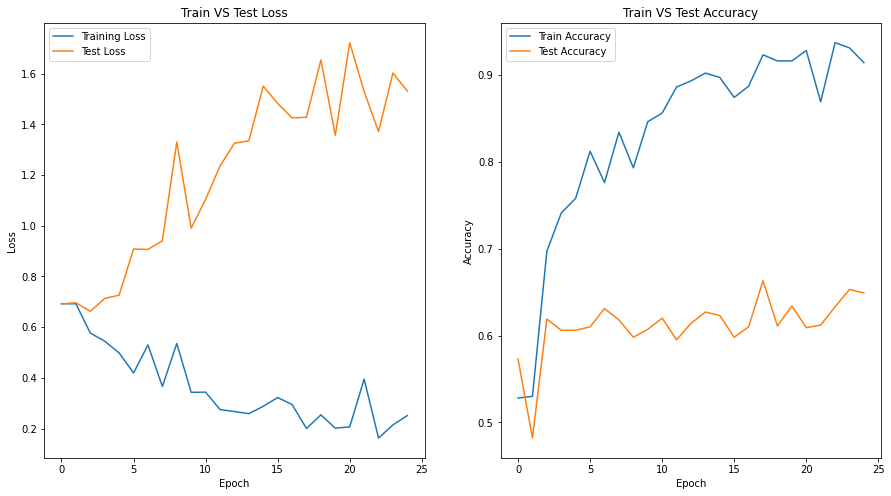

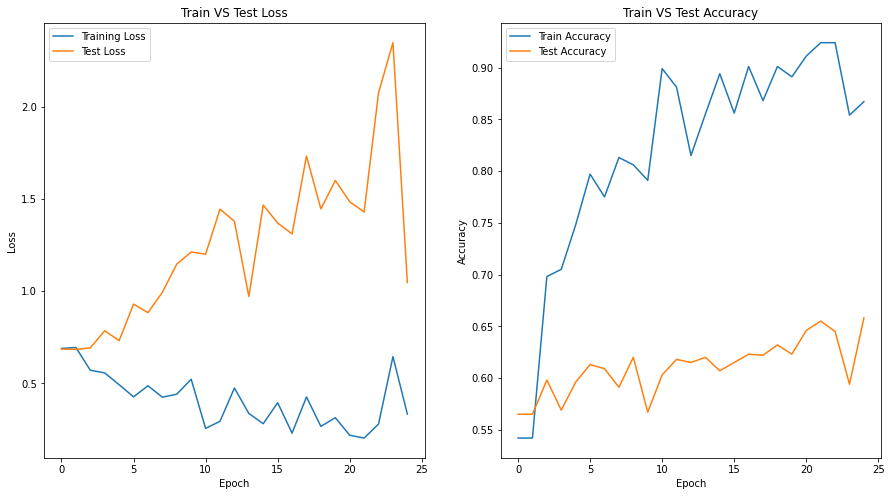

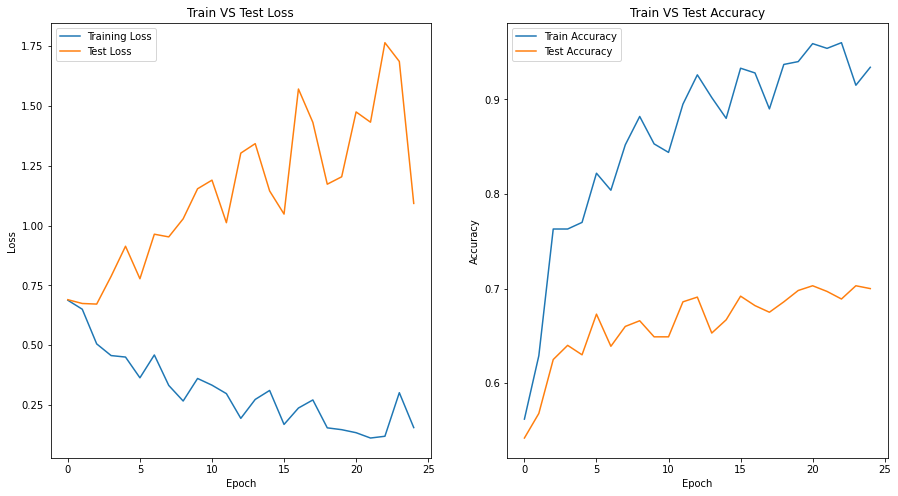

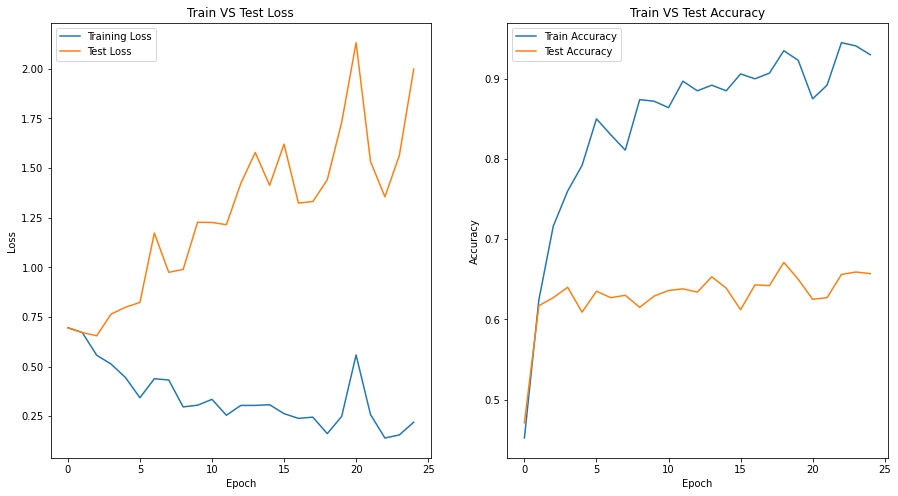

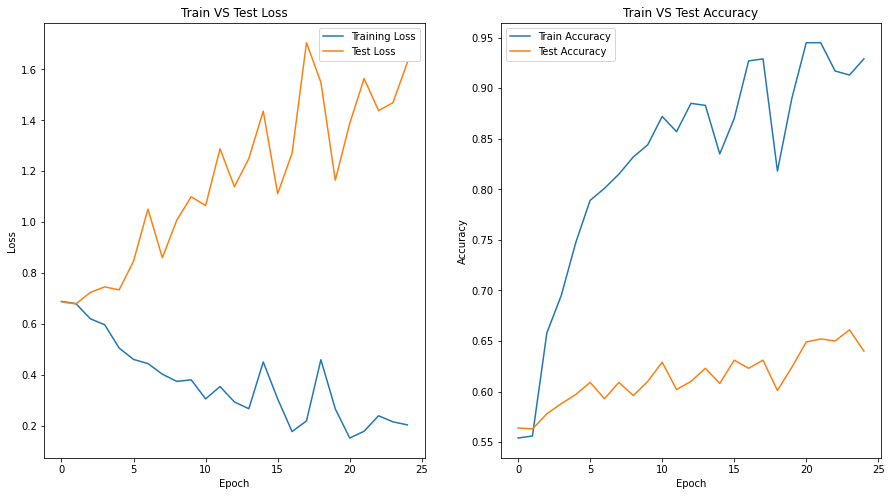

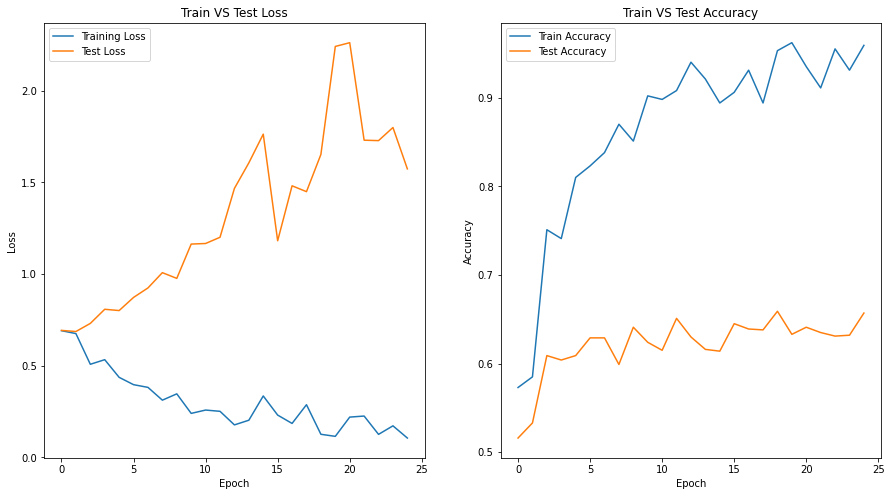

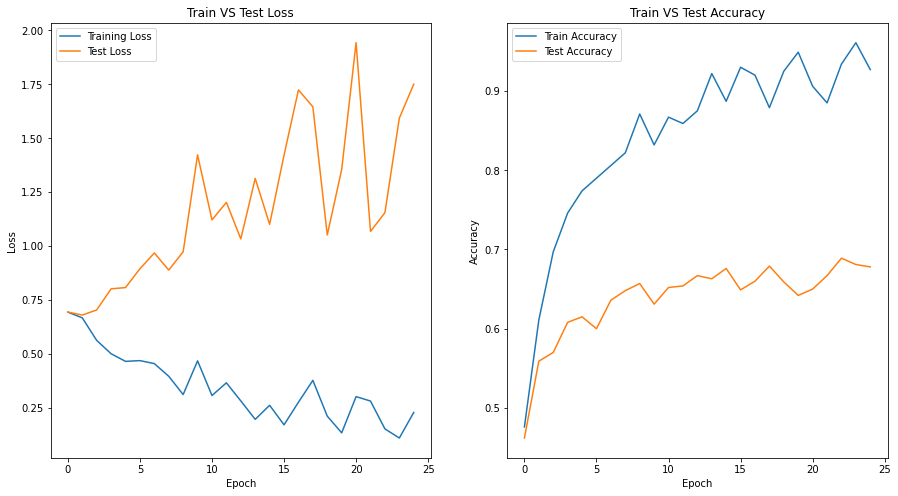

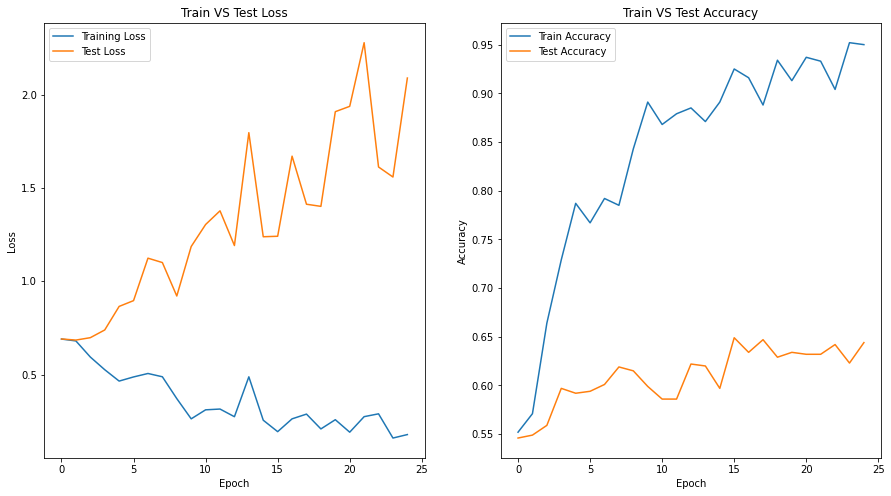

In [11]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    my_model = ResNet()
    # train the model
    my_model.trainer(train_input, train_target,test_input, test_target)
    train_errors.append(my_model.compute_error(train_input, train_target))
    test_errors.append(my_model.compute_error(test_input, test_target))

In [12]:
print('The standard deviation of train error:',np.std(train_errors))
print('The standard deviation of test error:',np.std(test_errors))
print('The mean of train error: ',np.mean(train_errors))
print('The mean of test error:',np.mean(test_errors))

The standard deviation of train error: 0.027997144735058075
The standard deviation of test error: 0.018719240232237512
The mean of train error:  0.07640000581741332
The mean of test error: 0.34330000877380373


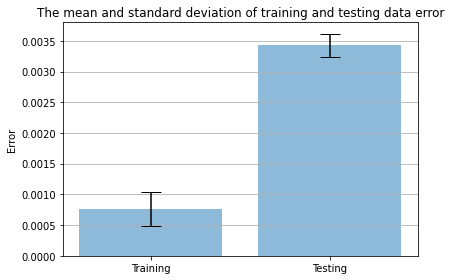

In [13]:
#plot the standard 
# Define labels, positions, bar heights and error bar heights
labels = ['Training', 'Testing']
x_pos = np.arange(len(labels))
means = [np.mean(train_errors)/100, np.mean(test_errors)/100]
stds = [np.std(np.divide(train_errors, 100)), np.std(np.divide(test_errors, 100))]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means,
       yerr=stds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('The mean and standard deviation of training and testing data error')
ax.yaxis.grid(True)

# show the plot
plt.tight_layout()
plt.show()